In [14]:
!pip install seaborn
!pip install kagglehub

🔎 missing values:
 generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                                  18
generation waste           

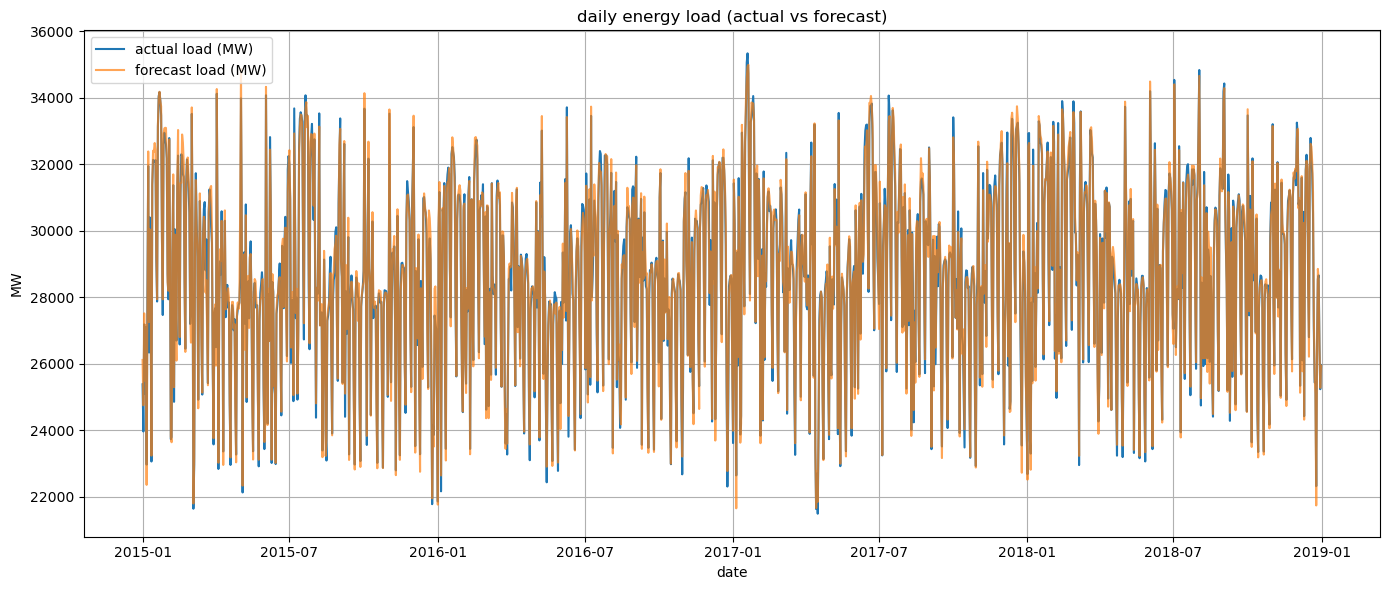

In [15]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# set file path
base_path = r"C:\Users\luthi\Documents\datasets"
file_path = os.path.join(base_path, "energy_dataset.csv")

# load dataset
df = pd.read_csv(file_path)

# parse date column (timezone-aware)
df['time'] = pd.to_datetime(df['time'], utc=True)
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# handle missing values
print("🔎 missing values:\n", df.isnull().sum())
df = df.ffill()  # forward fill using modern syntax

# resample to daily data
df_daily = df.resample('D').mean()

# plot total energy consumption over time
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily['total load actual'], label='actual load (MW)', color='tab:blue')
plt.plot(df_daily.index, df_daily['total load forecast'], label='forecast load (MW)', color='tab:orange', alpha=0.7)
plt.title("daily energy load (actual vs forecast)")
plt.xlabel("date")
plt.ylabel("MW")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\WINDOWS\Temp\ipykernel_7032\718874379.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()
C:\WINDOWS\Temp\ipykernel_7032\718874379.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_monthly_filtered['month_year'] = df_monthly_filtered['time'].dt.to_period('M').astype(str)


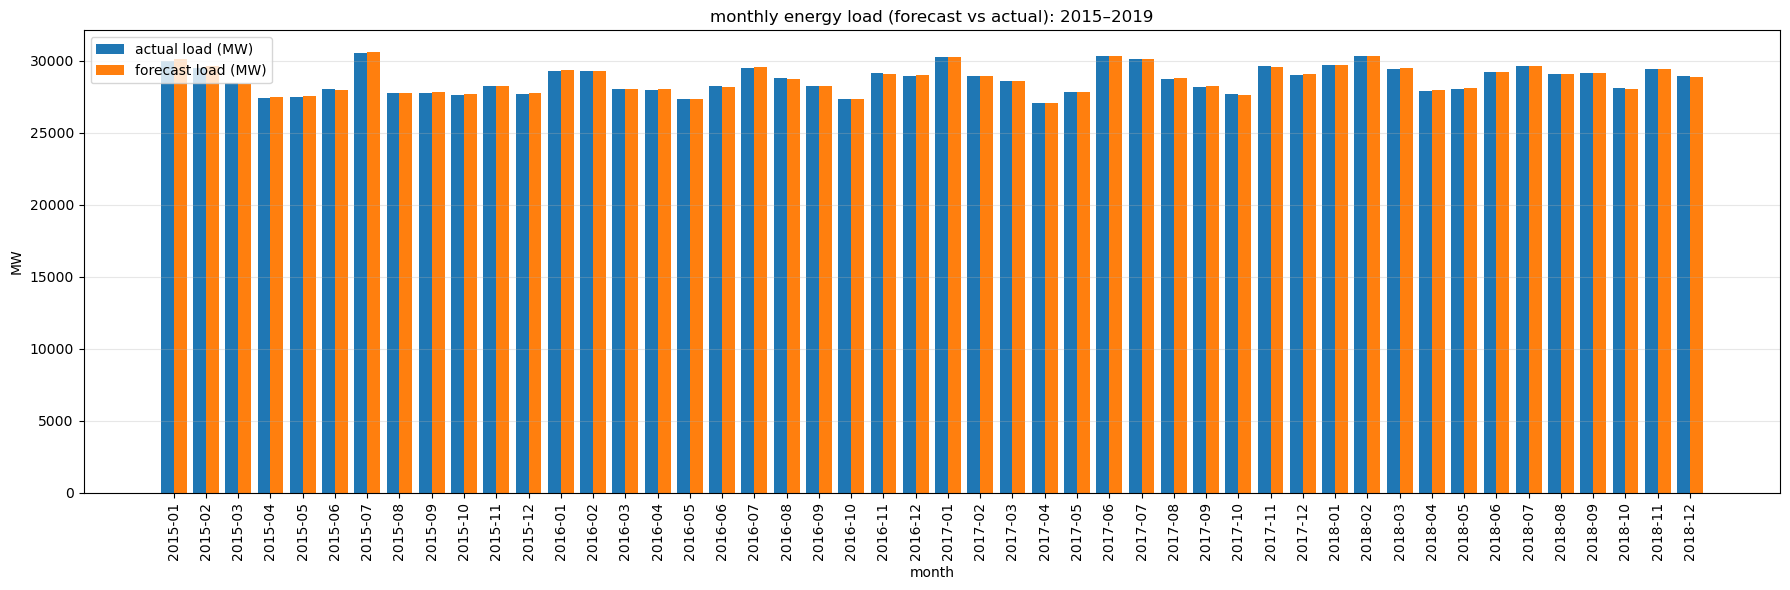

In [16]:
# resample to monthly data
df_monthly = df.resample('M').mean()

# filter for 2015 to 2019 only
df_monthly_filtered = df_monthly.loc['2015-01-01':'2019-12-31']

# reset index for plotting
df_monthly_filtered = df_monthly_filtered.reset_index()

# format month names for x-axis
df_monthly_filtered['month_year'] = df_monthly_filtered['time'].dt.to_period('M').astype(str)

# plot bar chart
plt.figure(figsize=(18, 6))
x = np.arange(len(df_monthly_filtered))
bar_width = 0.4

plt.bar(x - bar_width/2, df_monthly_filtered['total load actual'], width=bar_width, label='actual load (MW)', color='tab:blue')
plt.bar(x + bar_width/2, df_monthly_filtered['total load forecast'], width=bar_width, label='forecast load (MW)', color='tab:orange')

plt.title("monthly energy load (forecast vs actual): 2015–2019")
plt.xlabel("month")
plt.ylabel("MW")
plt.xticks(x, df_monthly_filtered['month_year'], rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


C:\WINDOWS\Temp\ipykernel_7032\360925746.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()


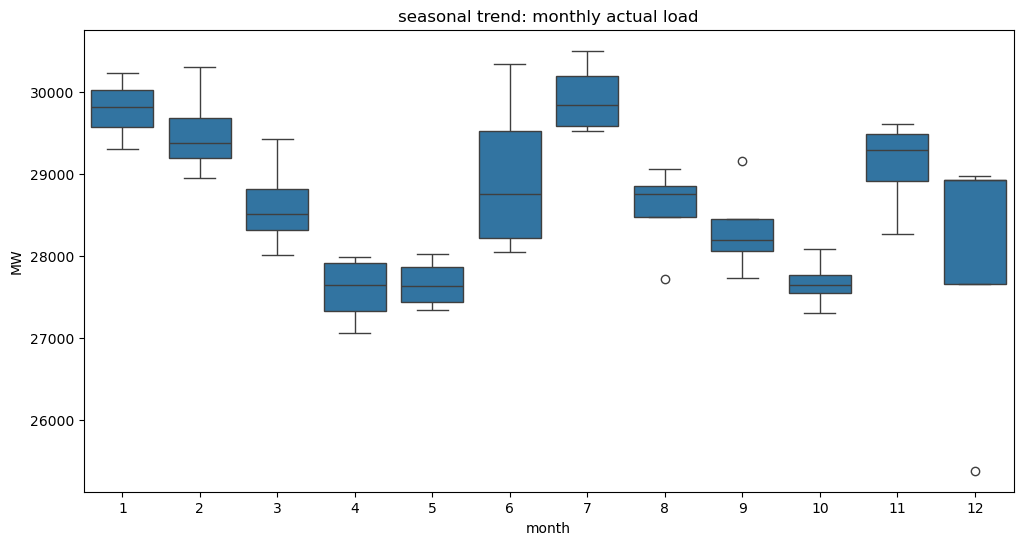

In [17]:
# monthly trends of actual load
df_monthly = df.resample('M').mean()
df_monthly['month'] = df_monthly.index.month
df_monthly['year'] = df_monthly.index.year

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='total load actual', data=df_monthly)
plt.title("seasonal trend: monthly actual load")
plt.xlabel("month")
plt.ylabel("MW")
plt.show()

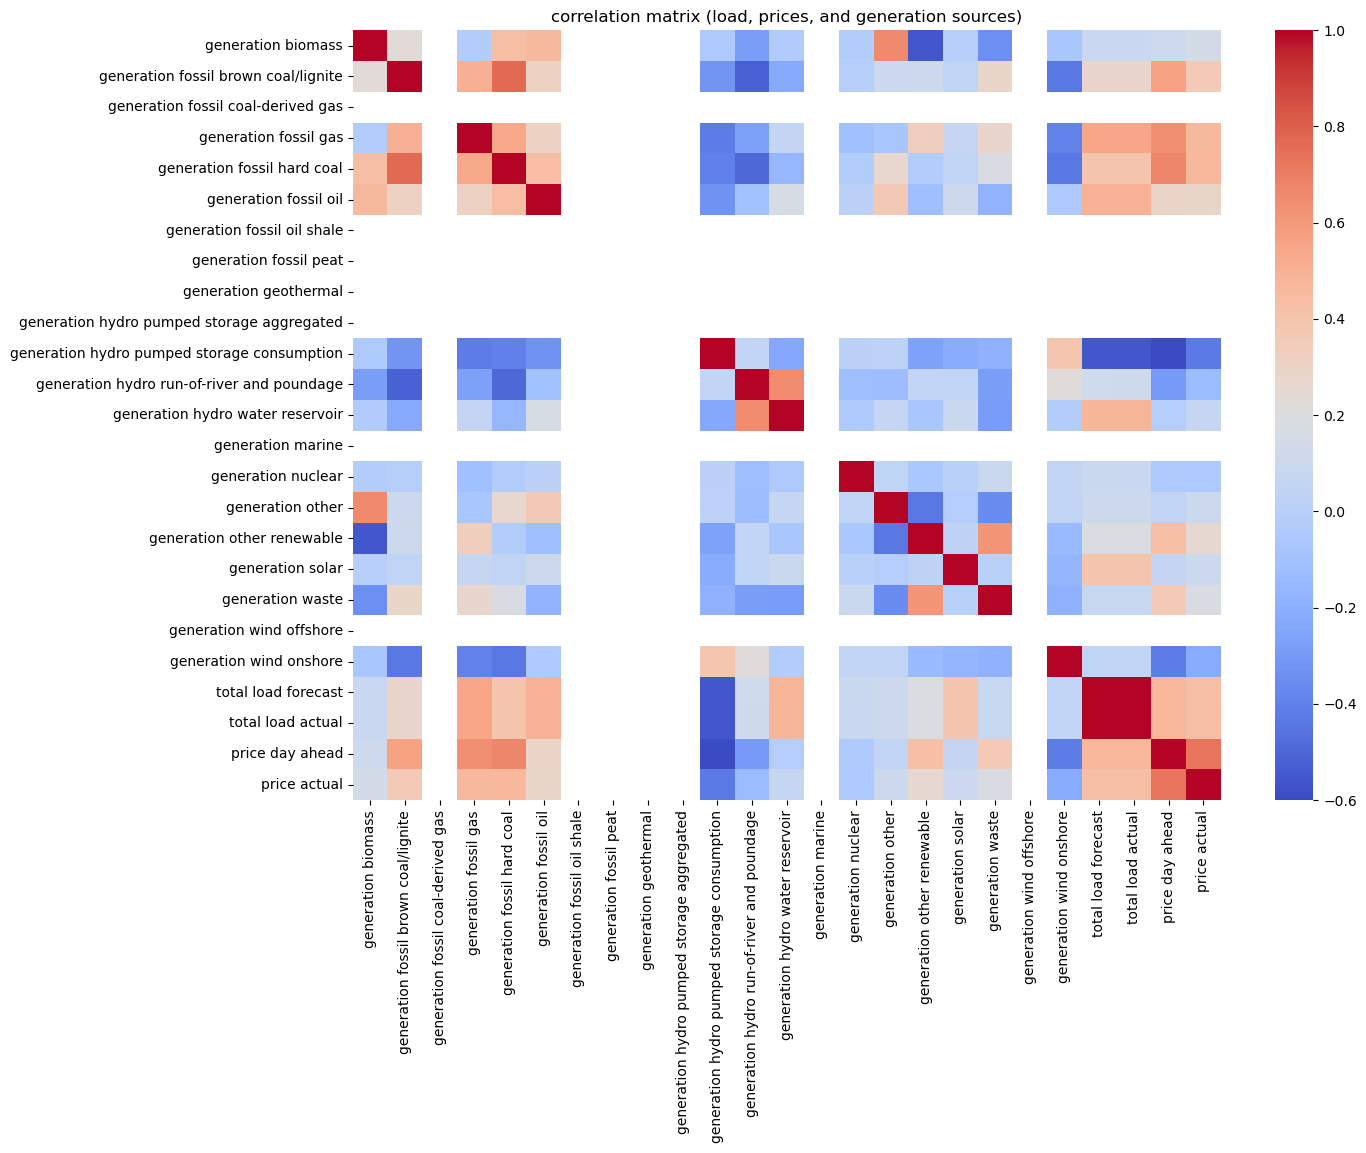

In [18]:

# correlation matrix for generation sources and prices
cols_of_interest = [col for col in df.columns if 'generation' in col or 'price' in col or 'total load' in col]
corr_matrix = df[cols_of_interest].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("correlation matrix (load, prices, and generation sources)")
plt.show()

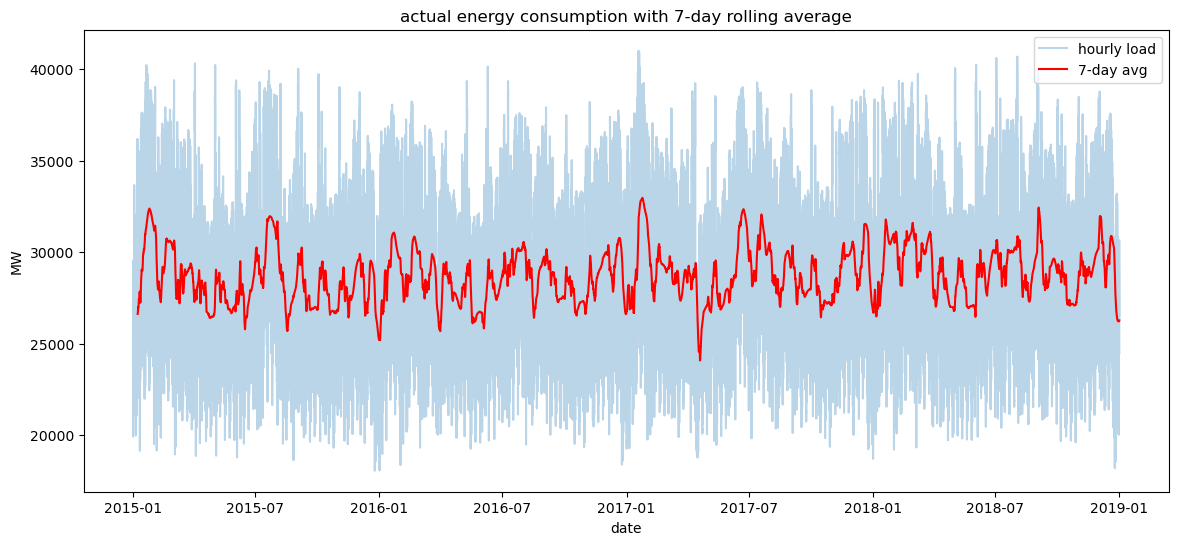

In [19]:
# compute 7-day rolling average of actual load
df['load_7day_avg'] = df['total load actual'].rolling(window=24*7).mean()

# plot 7-day rolling average
plt.figure(figsize=(14, 6))
plt.plot(df['total load actual'], alpha=0.3, label='hourly load')
plt.plot(df['load_7day_avg'], label='7-day avg', color='red')
plt.title("actual energy consumption with 7-day rolling average")
plt.xlabel("date")
plt.ylabel("MW")
plt.legend()
plt.show()


C:\WINDOWS\Temp\ipykernel_7032\3271813798.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()


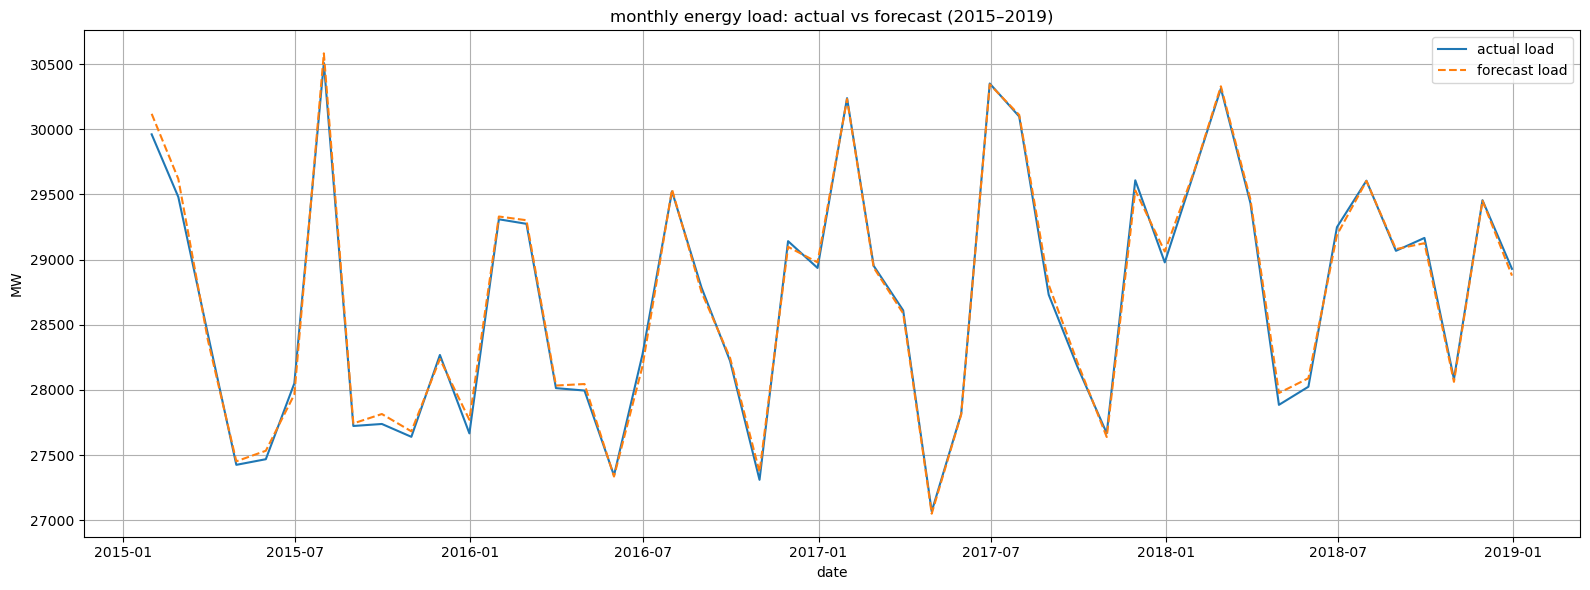

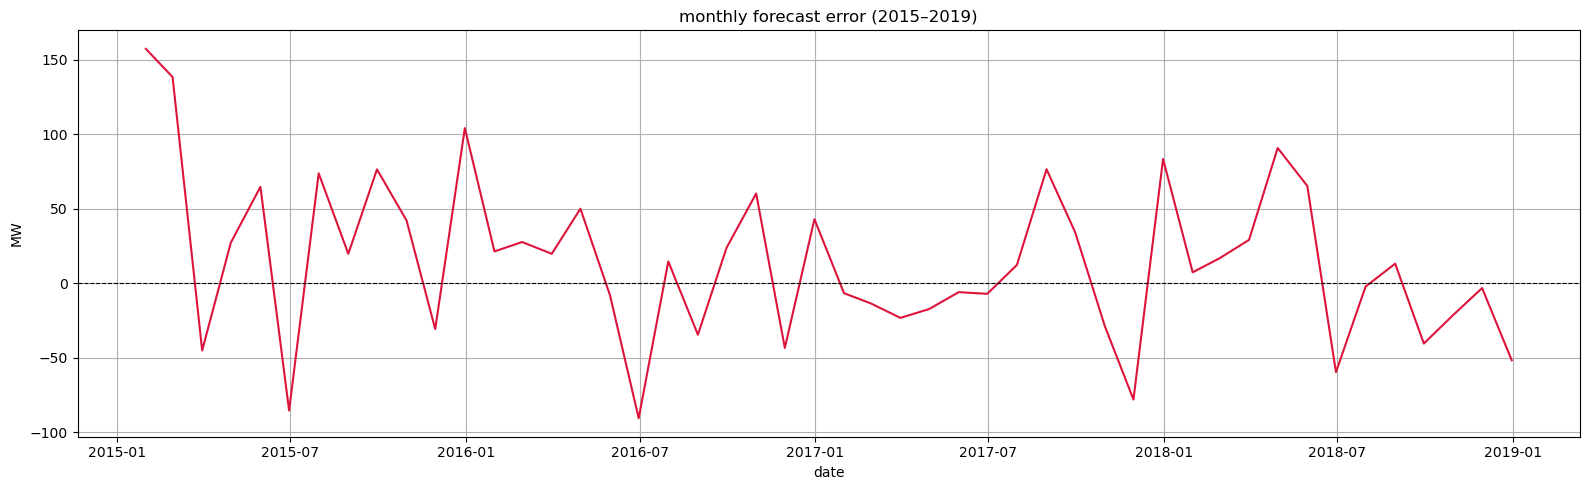

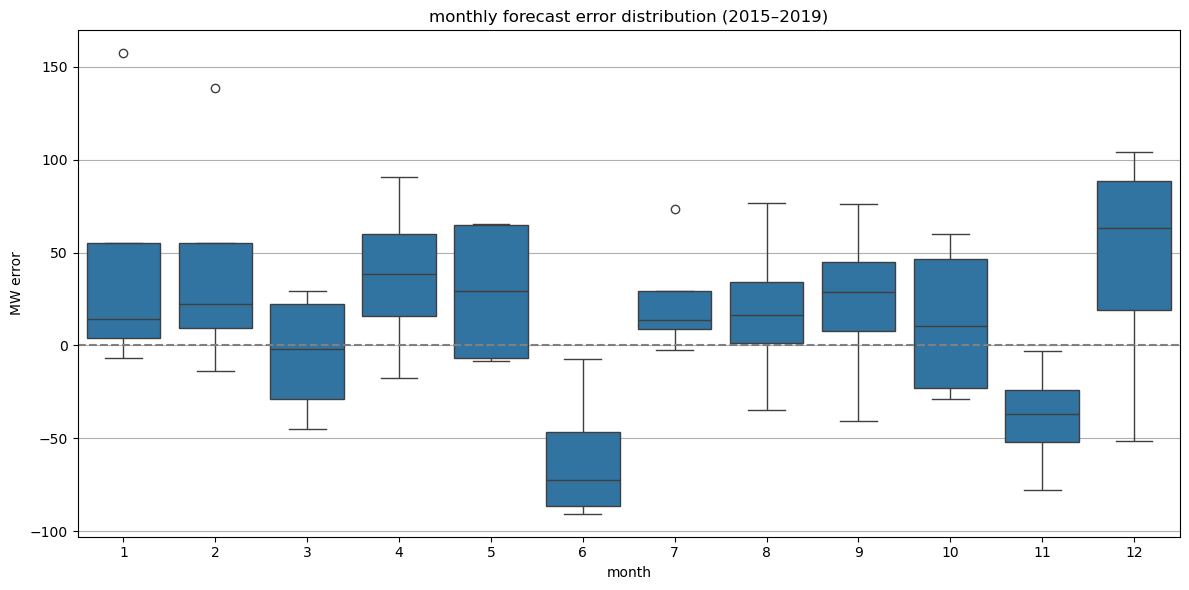

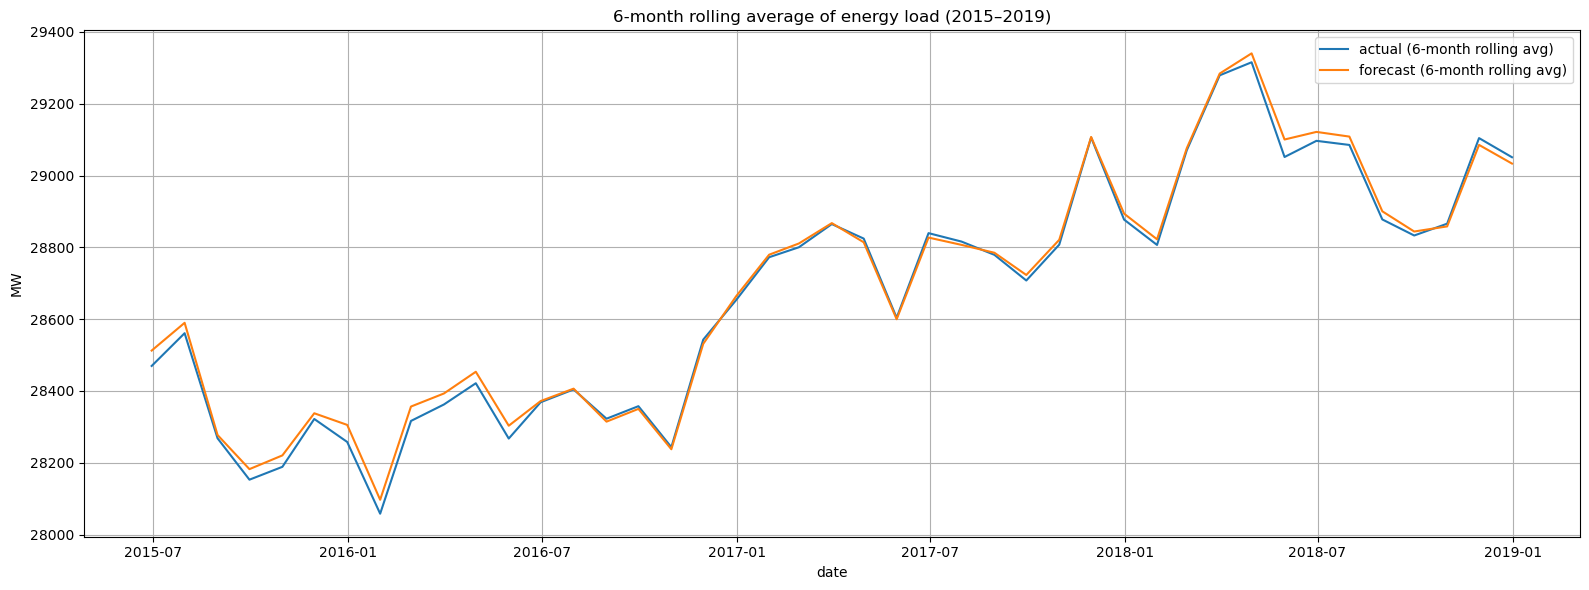

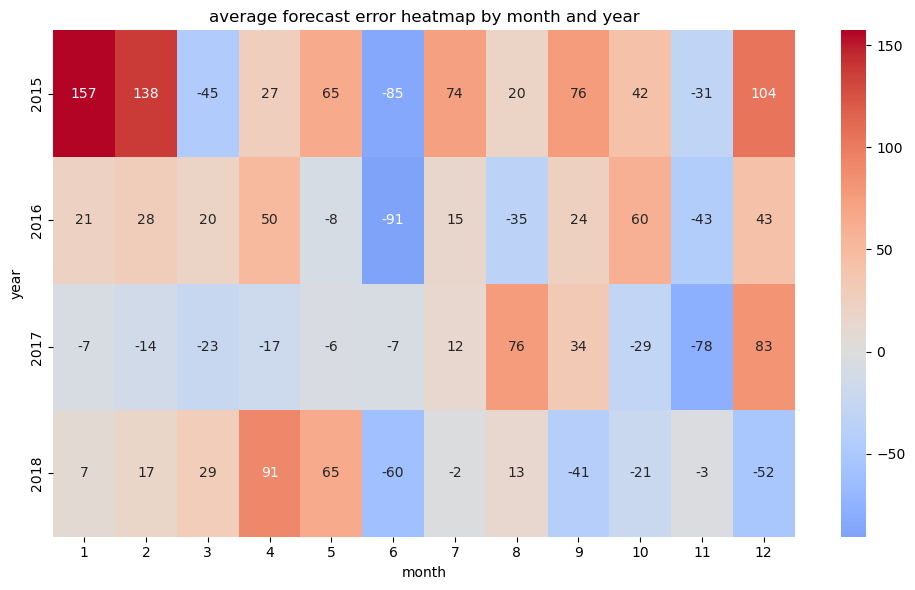

In [20]:
# focus on 2015–2019 data
df_monthly = df.resample('M').mean()
df_filtered = df_monthly.loc['2015-01-01':'2019-12-31'].copy()
df_filtered['error'] = df_filtered['total load forecast'] - df_filtered['total load actual']
df_filtered['abs_error'] = df_filtered['error'].abs()
df_filtered['month'] = df_filtered.index.month
df_filtered['year'] = df_filtered.index.year

# 1. line chart of actual vs forecast
plt.figure(figsize=(16, 6))
plt.plot(df_filtered.index, df_filtered['total load actual'], label='actual load', color='tab:blue')
plt.plot(df_filtered.index, df_filtered['total load forecast'], label='forecast load', color='tab:orange', linestyle='--')
plt.title("monthly energy load: actual vs forecast (2015–2019)")
plt.xlabel("date")
plt.ylabel("MW")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 2. forecast error over time
plt.figure(figsize=(16, 5))
plt.plot(df_filtered.index, df_filtered['error'], label='forecast error (forecast - actual)', color='crimson')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("monthly forecast error (2015–2019)")
plt.xlabel("date")
plt.ylabel("MW")
plt.grid()
plt.tight_layout()
plt.show()

# 3. boxplot of forecast error by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='error', data=df_filtered)
plt.axhline(0, color='gray', linestyle='--')
plt.title("monthly forecast error distribution (2015–2019)")
plt.xlabel("month")
plt.ylabel("MW error")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 4. rolling average to highlight long-term trend
df_filtered['actual_rolling'] = df_filtered['total load actual'].rolling(window=6).mean()
df_filtered['forecast_rolling'] = df_filtered['total load forecast'].rolling(window=6).mean()

plt.figure(figsize=(16, 6))
plt.plot(df_filtered.index, df_filtered['actual_rolling'], label='actual (6-month rolling avg)', color='tab:blue')
plt.plot(df_filtered.index, df_filtered['forecast_rolling'], label='forecast (6-month rolling avg)', color='tab:orange')
plt.title("6-month rolling average of energy load (2015–2019)")
plt.xlabel("date")
plt.ylabel("MW")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 5. heatmap of forecast error by month and year
pivot = df_filtered.pivot_table(values='error', index='year', columns='month')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm", center=0)
plt.title("average forecast error heatmap by month and year")
plt.xlabel("month")
plt.ylabel("year")
plt.tight_layout()
plt.show()


In [21]:
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,load_7day_avg
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41,NaN
2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92,NaN
2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48,NaN
2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32,NaN
2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04,NaN


In [35]:

# set file path
base_path = r"C:\Users\luthi\Documents\datasets"
file_path = os.path.join(base_path, "weather_features.csv")

# load dataset
df = pd.read_csv(file_path)
df.head()



,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [41]:
# filter for 2015–2019
df_filtered = df.loc['2015-01-01':'2019-12-31'].copy()

# keep only numeric columns
numeric_df = df_filtered.select_dtypes(include=['number'])

# resample to monthly mean values
df_monthly = numeric_df.resample('M').mean()

# add extra columns for plotting
df_monthly['month'] = df_monthly.index.month
df_monthly['year'] = df_monthly.index.year

# convert temperature from Kelvin to Celsius
df_monthly['temp_C'] = df_monthly['temp'] - 273.15
df_monthly['temp_min_C'] = df_monthly['temp_min'] - 273.15
df_monthly['temp_max_C'] = df_monthly['temp_max'] - 273.15


C:\WINDOWS\Temp\ipykernel_7032\3872721188.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = numeric_df.resample('M').mean()


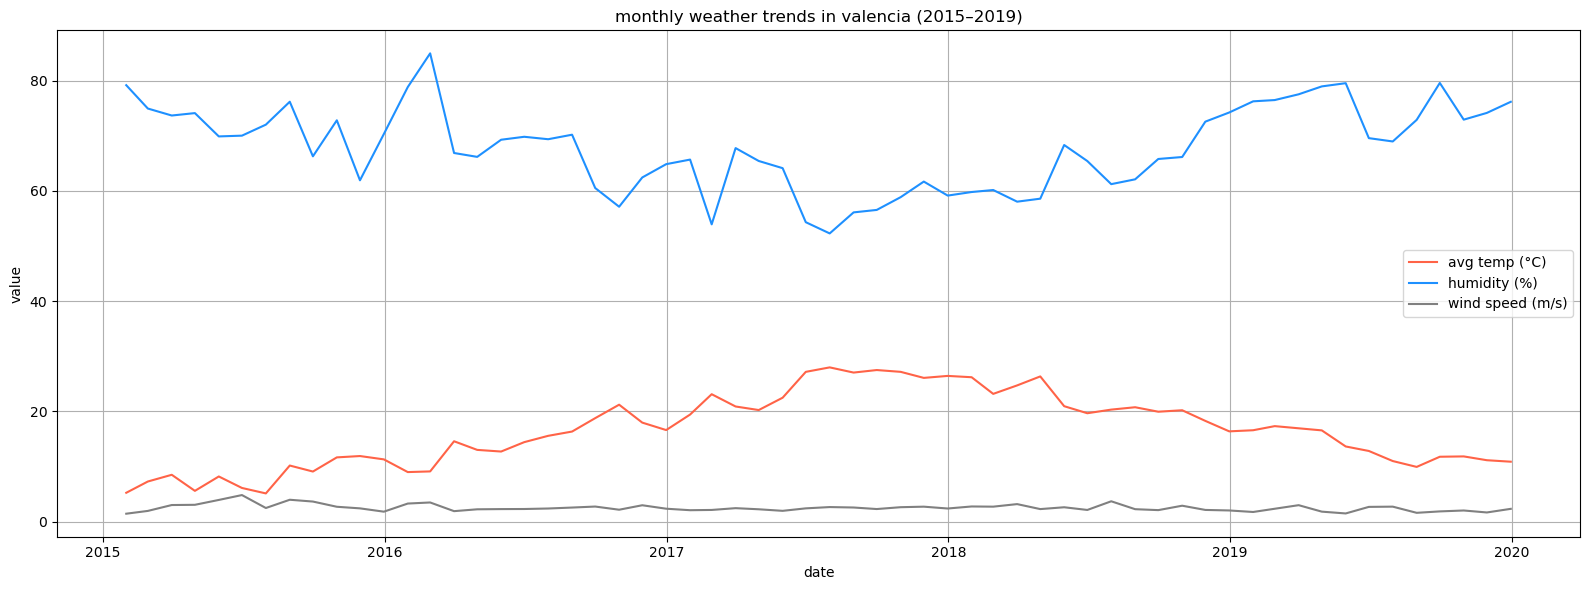

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
plt.plot(df_monthly.index, df_monthly['temp_C'], label='avg temp (°C)', color='tomato')
plt.plot(df_monthly.index, df_monthly['humidity'], label='humidity (%)', color='dodgerblue')
plt.plot(df_monthly.index, df_monthly['wind_speed'], label='wind speed (m/s)', color='gray')
plt.title("monthly weather trends in valencia (2015–2019)")
plt.xlabel("date")
plt.ylabel("value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


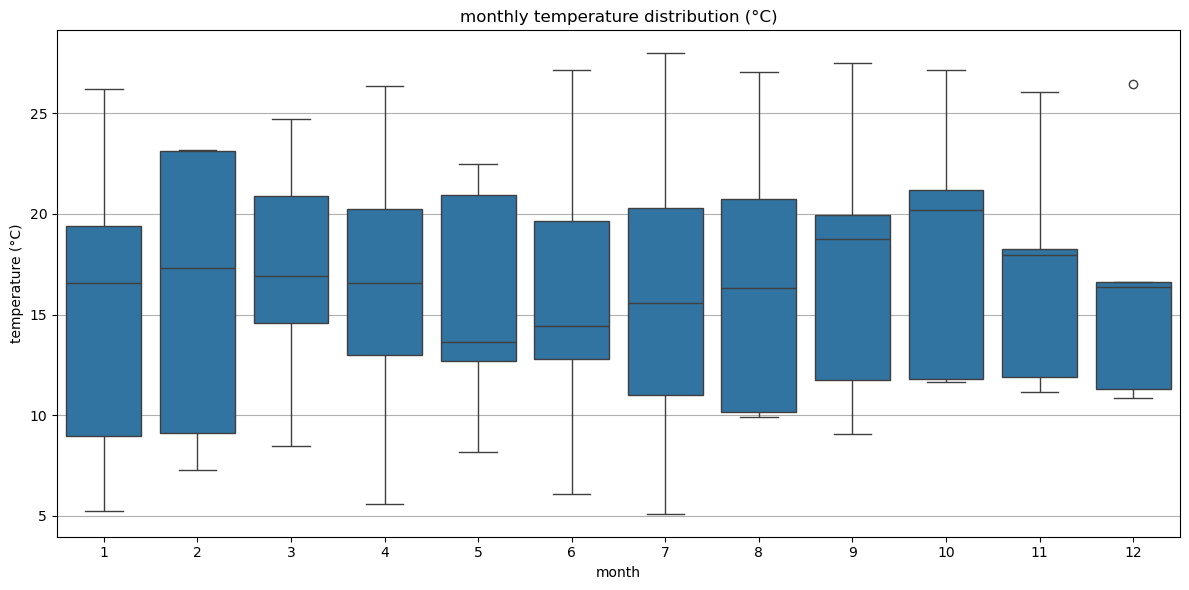

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp_C', data=df_monthly)
plt.title("monthly temperature distribution (°C)")
plt.xlabel("month")
plt.ylabel("temperature (°C)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


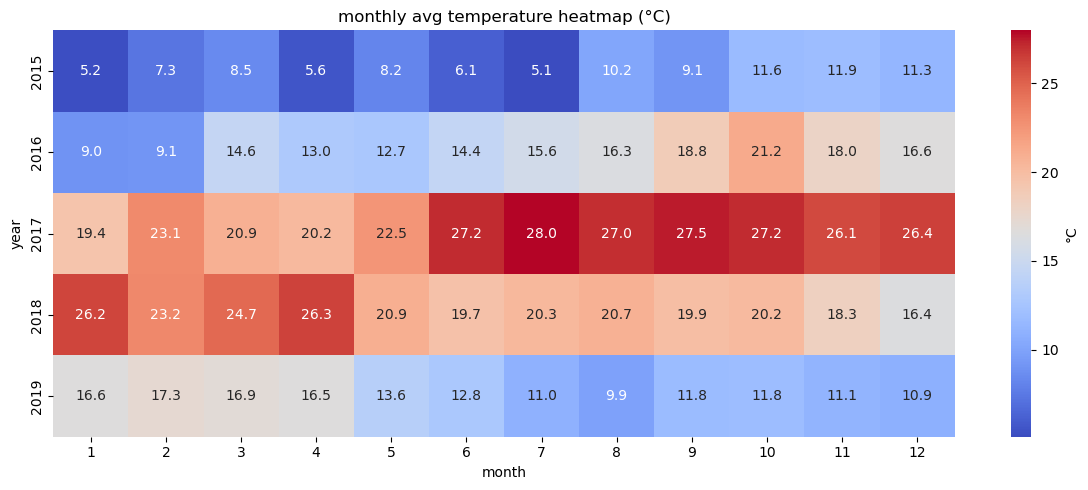

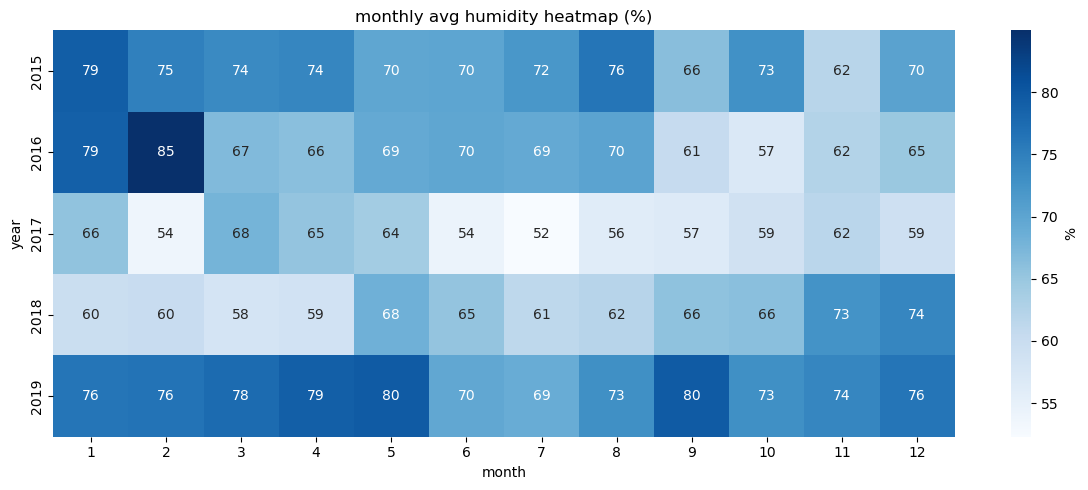

In [44]:
# pivot temperature and humidity
pivot_temp = df_monthly.pivot_table(values='temp_C', index='year', columns='month')
pivot_humidity = df_monthly.pivot_table(values='humidity', index='year', columns='month')

# temperature heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(pivot_temp, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': '°C'})
plt.title("monthly avg temperature heatmap (°C)")
plt.xlabel("month")
plt.ylabel("year")
plt.tight_layout()
plt.show()

# humidity heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(pivot_humidity, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': '%'})
plt.title("monthly avg humidity heatmap (%)")
plt.xlabel("month")
plt.ylabel("year")
plt.tight_layout()
plt.show()


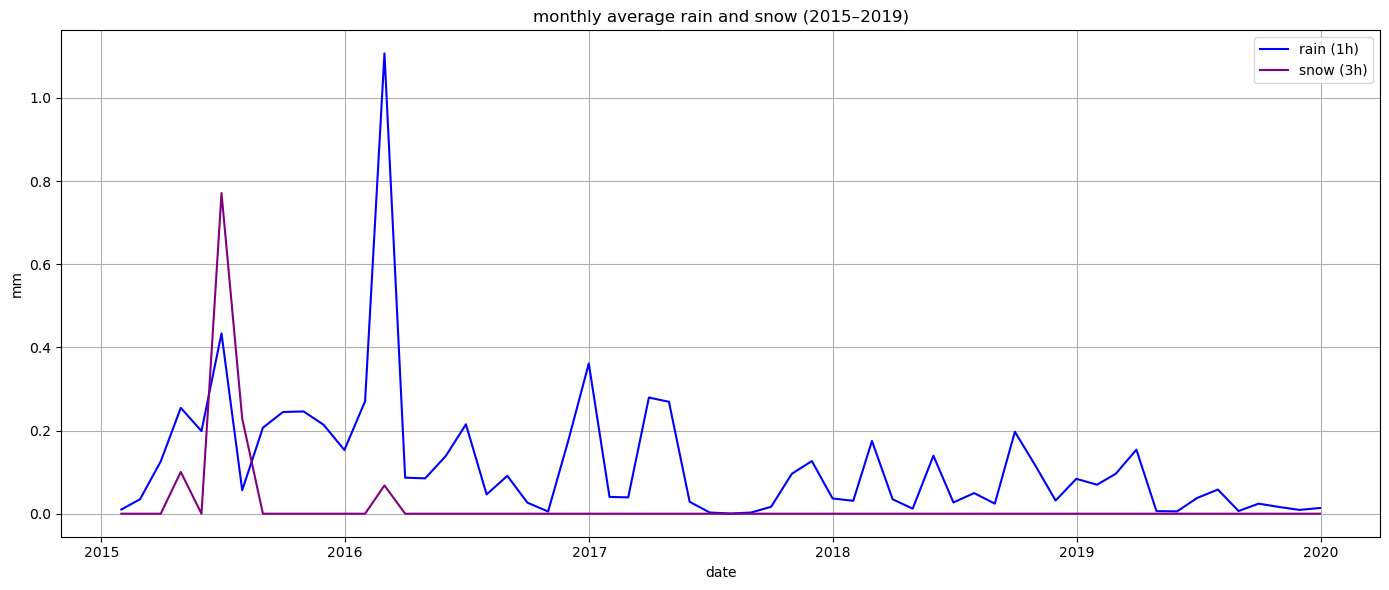

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly['rain_1h'], label='rain (1h)', color='blue')
plt.plot(df_monthly.index, df_monthly['snow_3h'], label='snow (3h)', color='purple')
plt.title("monthly average rain and snow (2015–2019)")
plt.xlabel("date")
plt.ylabel("mm")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


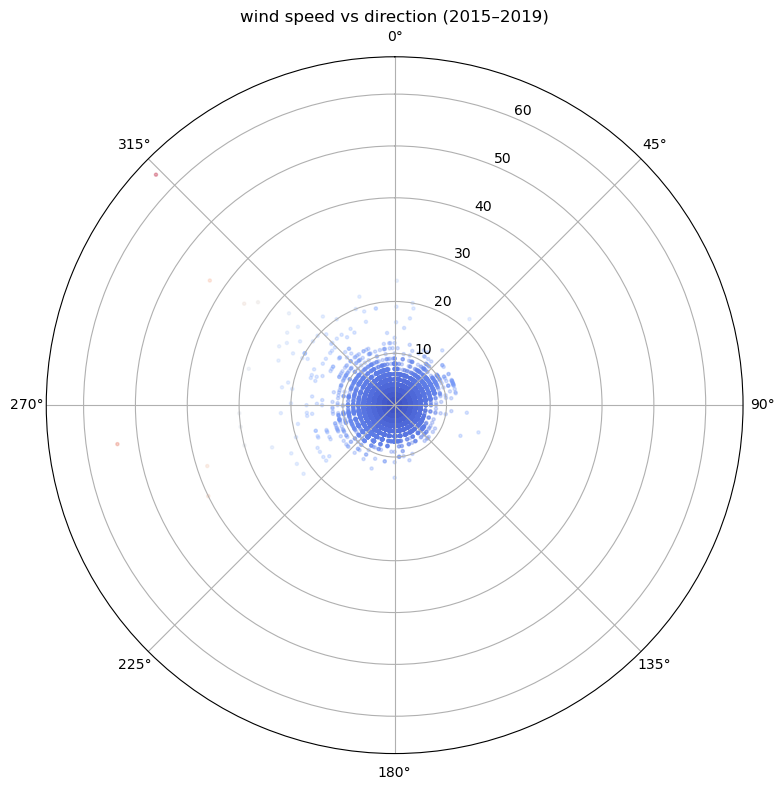

In [46]:
import numpy as np

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# convert degrees to radians
wind_dir_rad = np.deg2rad(df_filtered['wind_deg'])
wind_speed = df_filtered['wind_speed']

ax.scatter(wind_dir_rad, wind_speed, alpha=0.3, s=5, c=wind_speed, cmap='coolwarm')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title("wind speed vs direction (2015–2019)")
plt.tight_layout()
plt.show()
